# Jupyter Notebook backend demo

This example shows how vispy's low-level gloo interface can be used to display a Canvas in a notebook. By default, vispy will detect that it is being run in a notebook and load the "jupyter_rfb" backend automatically. This does require that the "jupyter_rfb" package be installed.

Due to the way widgets work in Jupyter, you can display the Canvas multiple times, but they will continue to represent the same object. In the case of timers, they will continue to run in the backgroudn until they are stopped, even if the output of your notebook cell is cleared and no canvas is visible.

In [12]:
import numpy as np
import vispy
import vispy.gloo as gloo
from vispy import app
from vispy import io
from vispy.util.transforms import perspective, translate, rotate

In [13]:
n = 100
a_position = np.random.uniform(-1, 1, (n, 3)).astype(np.float32)
a_id = np.random.randint(0, 30, (n, 1))
a_id = np.sort(a_id, axis=0).astype(np.float32)

In [14]:
VERT_SHADER = """
uniform mat4 u_model;
uniform mat4 u_view;
uniform mat4 u_projection;
attribute vec3 a_position;
attribute float a_id;
varying float v_id;
void main (void) {
    v_id = a_id;
    gl_Position = u_projection * u_view * u_model * vec4(a_position,1.0);
}
"""

FRAG_SHADER = """
varying float v_id;
void main()
{
    float f = fract(v_id);
    // The second useless test is needed on OSX 10.8 (fuck)
    if( (f > 0.0001) && (f < .9999) )
        discard;
    else
        gl_FragColor = vec4(0,0,0,1);
}
"""

In [15]:
class Canvas(app.Canvas):

    # ---------------------------------
    def __init__(self, size=None, show=True):
        app.Canvas.__init__(self, keys='interactive', size=size)

        self.program = gloo.Program(VERT_SHADER, FRAG_SHADER)

        # Set uniform and attribute
        self.program['a_id'] = gloo.VertexBuffer(a_id)
        self.program['a_position'] = gloo.VertexBuffer(a_position)

        self.translate = 5
        self.view = translate((0, 0, -self.translate), dtype=np.float32)
        self.model = np.eye(4, dtype=np.float32)

        gloo.set_viewport(0, 0, self.physical_size[0], self.physical_size[1])
        self.projection = perspective(45.0, self.size[0] /
                                      float(self.size[1]), 1.0, 1000.0)
        self.program['u_projection'] = self.projection

        self.program['u_model'] = self.model
        self.program['u_view'] = self.view

        self.theta = 0
        self.phi = 0

        self.context.set_clear_color('white')
        self.context.set_state('translucent')

        self.timer = app.Timer('auto', connect=self.on_timer, start=True)

        if show:
            self.show()

    # ---------------------------------
    def on_key_press(self, event):
        if event.text == ' ':
            if self.timer.running:
                self.timer.stop()
            else:
                self.timer.start()

    # ---------------------------------
    def on_timer(self, event):
        self.theta += .5
        self.phi += .5
        self.model = np.dot(rotate(self.theta, (0, 0, 1)),
                            rotate(self.phi, (0, 1, 0)))
        self.program['u_model'] = self.model
        self.update()

    # ---------------------------------
    def on_resize(self, event):
        gloo.set_viewport(0, 0, event.physical_size[0], event.physical_size[1])
        self.projection = perspective(45.0, event.size[0] /
                                      float(event.size[1]), 1.0, 1000.0)
        self.program['u_projection'] = self.projection

    # ---------------------------------
    def on_mouse_wheel(self, event):
        self.translate += event.delta[1]
        self.translate = max(2, self.translate)
        self.view = translate((0, 0, -self.translate))
        self.program['u_view'] = self.view
        self.update()

    # ---------------------------------
    def on_draw(self, event):
        self.context.clear()
        self.program.draw('line_strip')

Every cell above was preparing our GL Canvas for operation. Now we will create the Canvas instance and because of the `self.show()` in our `__init__` method our canvas will be shown and its timer started immediately.

RFBOutputContext()

CanvasBackend(css_width='300px')
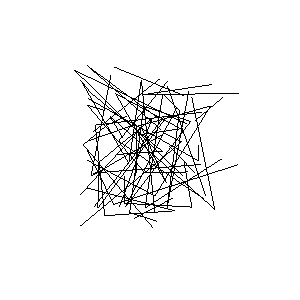

In [16]:
c = Canvas(size=(300, 300))
c

When timers are involved we can run the `stop` and `start` methods to turn them on/off and see the result in the widget displayed above.

In [17]:
c.timer.stop()

In [18]:
c.timer.start()

In [19]:
img=c.render('line_strip')
vispy.io.image.write_png("vispy.png", img)